## Example Dataset

In [1]:
import lale.datasets
(train_X, train_y), (test_X, test_y) = lale.datasets.covtype_df(test_size=0.9)

In [2]:
print(f'shape train_X {train_X.shape}, test_X {test_X.shape}')

shape train_X (58101, 54), test_X (522911, 54)


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index),
           train_X], axis=1).tail(10)

,y,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
58091,5,2771.0,57.0,25.0,323.0,108.0,342.0,228.0,178.0,69.0,2188.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58092,2,2633.0,108.0,14.0,182.0,21.0,764.0,243.0,223.0,106.0,1146.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58093,1,3099.0,240.0,16.0,228.0,57.0,2989.0,187.0,252.0,200.0,1485.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58094,2,2991.0,16.0,12.0,210.0,35.0,4049.0,210.0,215.0,141.0,1040.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58095,2,2712.0,44.0,14.0,511.0,32.0,1282.0,222.0,208.0,117.0,2759.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58096,1,3182.0,70.0,13.0,362.0,40.0,2992.0,234.0,214.0,109.0,4336.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58097,1,3172.0,156.0,29.0,716.0,291.0,1154.0,237.0,228.0,98.0,2837.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58098,1,3153.0,287.0,17.0,335.0,41.0,1298.0,171.0,237.0,205.0,2045.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58099,2,3065.0,348.0,21.0,124.0,19.0,4725.0,177.0,202.0,159.0,624.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58100,1,3021.0,26.0,16.0,60.0,7.0,3961.0,211.0,204.0,125.0,2496.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_X.json_schema

{'description': 'Features of forest covertypes dataset (classification).',
 'documentation_url': 'https://scikit-learn.org/0.20/datasets/index.html#forest-covertypes',
 'type': 'array',
 'items': {'type': 'array',
  'minItems': 54,
  'maxItems': 54,
  'items': [{'description': 'Elevation', 'type': 'integer'},
   {'description': 'Aspect', 'type': 'integer'},
   {'description': 'Slope', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Hydrology', 'type': 'integer'},
   {'description': 'Vertical_Distance_To_Hydrology', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Roadways', 'type': 'integer'},
   {'description': 'Hillshade_9am', 'type': 'integer'},
   {'description': 'Hillshade_Noon', 'type': 'integer'},
   {'description': 'Hillshade_3pm', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Fire_Points', 'type': 'integer'},
   {'description': 'Wilderness_Area1', 'enum': [0, 1]},
   {'description': 'Wilderness_Area2', 'enum': [0, 1]},
   {'descrip

## Manual Pipeline

In [5]:
from sklearn.decomposition import PCA
from xgboost import XGBClassifier as XGBoost
lale.wrap_imported_operators()

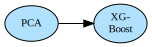

In [6]:
manual_trainable = PCA(n_components=6) >> XGBoost(n_estimators=3)
manual_trainable.visualize()

In [7]:
%%time
manual_trained = manual_trainable.fit(train_X, train_y)

CPU times: user 2.81 s, sys: 1.17 s, total: 3.98 s
Wall time: 2.87 s


In [8]:
import sklearn.metrics
manual_y = manual_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, manual_y):.1%}')

accuracy 65.7%


## Hyperparameter Tuning

In [9]:
XGBoost.hyperparam_schema('n_estimators')

{'description': 'Number of trees to fit.',
 'type': 'integer',
 'default': 100,
 'minimumForOptimizer': 10,
 'maximumForOptimizer': 1500}

In [10]:
from lale.lib.lale import Hyperopt
import lale.schemas as schemas

CustomPCA = PCA.customize_schema(n_components=schemas.Int(min=2, max=54))
CustomXGBoost = XGBoost.customize_schema(n_estimators=schemas.Int(min=1, max=10))

hpo_planned = CustomPCA >> CustomXGBoost
hpo_trainable = Hyperopt(estimator=hpo_planned, max_evals=10, cv=3)

In [11]:
%%time
hpo_trained = hpo_trainable.fit(train_X, train_y)

100%|███████| 10/10 [02:20<00:00, 12.15s/trial, best loss: -0.7965957865133036]
CPU times: user 2min 32s, sys: 14.2 s, total: 2min 46s
Wall time: 2min 34s


### --- TODO: picture for types as search spaces ---

In [12]:
hpo_y = hpo_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, hpo_y):.1%}')

accuracy 80.5%


## Inspecting Automation Results

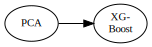

In [13]:
hpo_trained.get_pipeline().visualize()

In [14]:
hpo_trained.get_pipeline().pretty_print(ipython_display=True)

```python
from lale.lib.sklearn import PCA
from lale.lib.xgboost.xgb_classifier import XGBoost
import lale
lale.wrap_imported_operators()

pca = PCA(n_components=39, svd_solver='full')
xg_boost = XGBoost(colsample_bylevel=0.6016063807304212, colsample_bytree=0.7763972782064467, learning_rate=0.16389357351003786, max_depth=10, min_child_weight=5, n_estimators=5, reg_alpha=0.10485915855270356, reg_lambda=0.9268502695024392, subsample=0.4503841871781402)
pipeline = pca >> xg_boost
```

In [15]:
hpo_trained.summary()

,tid,loss,time,log_loss,status
name,,,,,
p0,0,-0.676563,2.289325,1.234038,ok
p1,1,-0.641228,2.260723,1.109479,ok
p2,2,-0.679868,4.282998,1.075010,ok
p3,3,-0.796596,9.674343,1.035531,ok
p4,4,-0.728645,7.815306,0.653845,ok
p5,5,-0.484122,4.691596,1.230732,ok
p6,6,-0.484122,2.189976,1.329945,ok
p7,7,-0.676546,3.754047,0.833122,ok
p8,8,-0.640195,3.110705,0.910650,ok


In [16]:
worst_name = hpo_trained.summary().loss.argmax()
print(worst_name)

p5


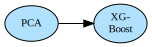

```python
pca = PCA(n_components=48, svd_solver='full', whiten=True)
xg_boost = XGBoost(booster='gblinear', colsample_bylevel=0.41777546097517426, colsample_bytree=0.6852556915729863, learning_rate=0.4299362917360751, max_depth=15, min_child_weight=18, n_estimators=7, reg_alpha=0.5266202371276923, reg_lambda=0.494226267796831, subsample=0.8015579071911012)
pipeline = pca >> xg_boost
```

In [17]:
hpo_trained.get_pipeline(worst_name).visualize()
hpo_trained.get_pipeline(worst_name).pretty_print(ipython_display=True, show_imports=False)

## Transparent Operators

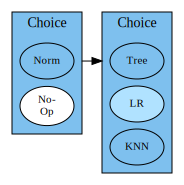

In [18]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import NoOp
lale.wrap_imported_operators()

KNN = KNN.customize_schema(n_neighbors=schemas.Int(min=1, max=10))
transp_planned = (Norm | NoOp) >> (Tree | LR(dual=False) | KNN)
transp_planned.visualize()

In [19]:
%%time
transp_trained = transp_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=5)

100%|█████████| 5/5 [03:09<00:00, 28.64s/trial, best loss: -0.8469388647297208]
CPU times: user 2min 58s, sys: 2.14 s, total: 3min
Wall time: 3min 13s


### ---  TODO: picture for bindings as lifecycle ---

```python
knn = KNN(algorithm='ball_tree', metric='manhattan', n_neighbors=9)
pipeline = NoOp() >> knn
```

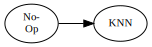

In [20]:
transp_trained.pretty_print(ipython_display=True, show_imports=False)
transp_trained.visualize()

In [21]:
%%time
transp_y = transp_trained.predict(test_X.head(50000))
print(f'accuracy {sklearn.metrics.accuracy_score(test_y.head(50000), transp_y):.1%}')

accuracy 87.4%
CPU times: user 1min 10s, sys: 328 ms, total: 1min 10s
Wall time: 1min 15s


## Non-Linear Pipeline

In [22]:
wild_columns = [f'Wilderness_Area{i}' for i in range(1, 5)]
soil_columns = [f'Soil_Type{i}' for i in range(1, 41)]
binary_columns = wild_columns + soil_columns
other_columns = [c for c in train_X.columns if c not in binary_columns]
print(f'other_columns == {other_columns}')

other_columns == ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


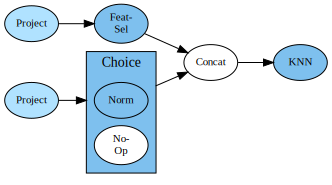

In [23]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Concat
from sklearn.feature_selection import SelectKBest as FeatSel
lale.wrap_imported_operators()

binary_prep = Project(columns=binary_columns) >> FeatSel
other_prep = Project(columns=other_columns) >> (Norm | NoOp)
nonlin_planned = (binary_prep & other_prep) >> Concat >> KNN
nonlin_planned.visualize()

In [24]:
%%time
nonlin_trained = nonlin_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=5)

100%|█████████| 5/5 [07:04<00:00, 66.05s/trial, best loss: -0.8688489904804216]
CPU times: user 6min 40s, sys: 1.61 s, total: 6min 41s
Wall time: 7min 7s


### --- TODO: table for combinators ---

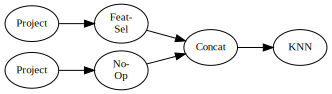

```python
project_0 = Project(columns=['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'])
feat_sel = FeatSel(k=8)
pipeline_0 = make_pipeline(project_0, feat_sel)
project_1 = Project(columns=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'])
pipeline_1 = make_pipeline(project_1, NoOp())
union = make_union(pipeline_0, pipeline_1)
knn = KNN(algorithm='kd_tree', n_neighbors=7, weights='distance')
pipeline = make_pipeline(union, knn)
```

In [25]:
nonlin_trained.visualize()
nonlin_trained.pretty_print(ipython_display=True, show_imports=False, combinators=False)

In [26]:
%%time
nonlin_y = nonlin_trained.predict(test_X.head(50000))
print(f'accuracy {sklearn.metrics.accuracy_score(test_y.head(50000), nonlin_y):.1%}')

accuracy 89.3%
CPU times: user 4.48 s, sys: 31.2 ms, total: 4.52 s
Wall time: 4.56 s
